In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import itertools
import math
from matplotlib.ticker import AutoMinorLocator
from functools import reduce

f_alg = {
    "SPM": "Small Progress Measures",
    "SCC_FB": "Forward-Backward",
    "SCC_COL": "Colouring/Heads-off",
    "synthesis": "Supervisory Controller Synthesis",
    "prefix_sum": "Prefix Sum"
};

f_order = {
    "relaxed": "Relaxed",
    "acqrel": "RA",
    "seqcons": "SC"
};

f_schedule = {
    "in-kernel": "In-kernel",
    "on-host": "On-host",
    "graph": "Graph"
};

order_color = {
    "relaxed": "C0",
    "acqrel": "C2",
    "seqcons": "C1"
};

alg_marker = {
    "SPM": ".",
    "SCC_FB": "4",
    "SCC_COL": "x",
    "synthesis": "v",
    "prefix_sum": "P"
};

opt_linestyles = {
    True: "-",
    False: (0, (1, 3))
};
    


algs_ptypes = [
    ("prefix_sum", "Random"),
    ("SCC_FB", "(P=1.3/N)"),
    ("SCC_COL", "(P=1.3/N)"),
    ("synthesis", "Random"),
    ("SPM", "Invariantly Inevitably Eat"),
    ("SPM", "Invariantly Plato Starves"),
];

def cols2rt(s, o, opt, v):
    return f"rt_{s}_{o}_{opt}_{v}";

def max_threads(s, alg):
    mt_per_alg_ik = {
        "SPM": 58880,
        "SCC_COL": 58880,
        "prefix_sum": 70656,
        "synthesis": 70656,
        "SCC_FB": 52992
    };
    if s == "graph" or s == "on-host":
        return 70656;
    else:
        return mt_per_alg_ik[alg];

threads_color = "black";
threads_ls = "--";#(0, (4, 8));
threads_alpha = 0.5;

# AuDaLa data
spm = pd.read_csv('SPM/SPM_results.csv', sep=',')
scc_col = pd.read_csv('SCC/SCC_COL_results.csv', sep=',')
scc_fb = pd.read_csv('SCC/SCC_FB_results.csv', sep=',')
#sorting = pd.read_csv('sorting/sorting_results.csv', sep=',')
prefix_sum = pd.read_csv('prefix_sum/prefix_sum_results.csv', sep=',')
synthesis = pd.read_csv('synthesis/synthesis_results.csv', sep=',')

all_data = [spm, scc_col, scc_fb, prefix_sum, synthesis];
cols = list(map((lambda d : d.columns), all_data));
assert (all([all(cols[i-1] == cols[i]) for i in range(1, len(cols))]));

data = pd.concat(all_data, ignore_index=True);
data = data.drop(data[data["runtime"] == "timeout"].index);
data["runtime"] = data["runtime"].astype(float);
data["problem_size1"] = data["problem_size1"].astype(int);
data["problem_size2"] = data["problem_size2"].astype(int);
data["problem_size3"] = data["problem_size3"].astype(int);
data["weak_non_racing"] = data["weak_non_racing"].astype(bool);

data.loc[:, "problem_size"] = data[["problem_size1", "problem_size2", "problem_size3"]].max(axis=1);


# Sequential data
synthesis_seq = pd.read_csv('synthesis/synthesis_sequential.csv', sep=',')
spm_seq = pd.read_csv('SPM/SPM_sequential.csv', sep=',')
prefix_sum_seq = pd.read_csv('prefix_sum/prefix_sum_sequential.csv', sep=',')
scc_seq = pd.read_csv('SCC/scc_sequential.csv', sep=',')

all_data = [synthesis_seq, spm_seq, prefix_sum_seq, scc_seq];
cols = list(map((lambda d : d.columns), all_data));
assert (all([all(cols[i-1] == cols[i]) for i in range(1, len(cols))]));
seq_data = pd.concat(all_data, ignore_index=True);
seq_data["runtime"] = seq_data["runtime"].astype(float);
seq_data["problem_size1"] = seq_data["problem_size1"].astype(int);
seq_data["problem_size2"] = seq_data["problem_size2"].astype(int);
seq_data["problem_size3"] = seq_data["problem_size3"].astype(int);
seq_data["problem_size"] = seq_data[["problem_size1", "problem_size2", "problem_size3"]].max(axis=1);


# Make df with (problem_size, algorithm, problem_type) as index and various runtimes in columns
bench_columns = list(data.groupby(["schedule", "memorder", "weak_non_racing", "voting-strat"]).groups.keys());
memory_orders = list(data["memorder"].unique());

prepped = pd.concat([
    data[
        (data["memorder"] == o) &
        (data["schedule"] == s) &
        (data["voting-strat"] == v) &
        (data["weak_non_racing"] == opt)
    ][["problem_size", "algorithm", "problem_type", "runtime"]]
    .set_index(["problem_size", "algorithm", "problem_type"])
    .rename(columns={"runtime": cols2rt(s,o,opt,v)})
    for (s, o, opt, v) in bench_columns
], axis = 1);
prepped.sort_index(inplace=True);


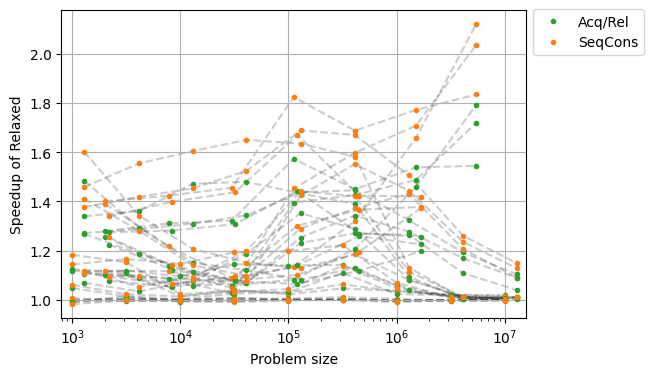

In [101]:
def memorder_scatter_chart(rows, algs_ptypes):
    marker = ".";
    
    fig, ax = plt.subplots(figsize=(6, 4));
    for (s, o, opt, v) in bench_columns:
        if o == "relaxed":
            continue;
        if not opt:
            continue;
        if not v.endswith("simple"):
            continue;

        rt_col = cols2rt(s, o, opt, v);
        rt_col_cmp = cols2rt(s, "relaxed", opt, v);
        
        for (a, pt) in algs_ptypes:
            alg_rows = rows.loc[
                (rows.index.get_level_values('algorithm') == a) &
                (rows.index.get_level_values('problem_type') == pt)
                , :
            ];
            ax.scatter(
                alg_rows.index.get_level_values('problem_size'),
                alg_rows[rt_col] / alg_rows[rt_col_cmp],
                color=order_color[o],
                marker=marker,
                zorder=3,
                #marker=alg_marker[a],
            )
            ax.plot(
                alg_rows.index.get_level_values('problem_size'),
                alg_rows[rt_col] / alg_rows[rt_col_cmp],
                color="black",
                alpha=0.2,
                linestyle="--",
                zorder=0
            )
        ax.set_xscale("log")
        ax.grid(True, zorder=0)
        #ax.set_xlabel("Runtime (ms)")
        ax.set_xlabel("Problem size")
        ax.set_ylabel("Speedup of Relaxed")
        ax.set_xlim(10**2.9, 10**7.2);
    
    #ax.axvline(70656, color=threads_color, alpha=threads_alpha, linestyle=threads_ls);
    
    patches = [
        Line2D(
            [0],
            [0],
            color=order_color[o],
            label=f"{f_order[o]}",
            marker=marker,
            linestyle="None"
        ) for o in ["acqrel", "seqcons"]
    ];
    
    fig.legend(handles=patches, bbox_to_anchor=(0.9, 0.9), loc="upper left")
    plt.show()

memorder_scatter_chart(prepped, algs_ptypes);


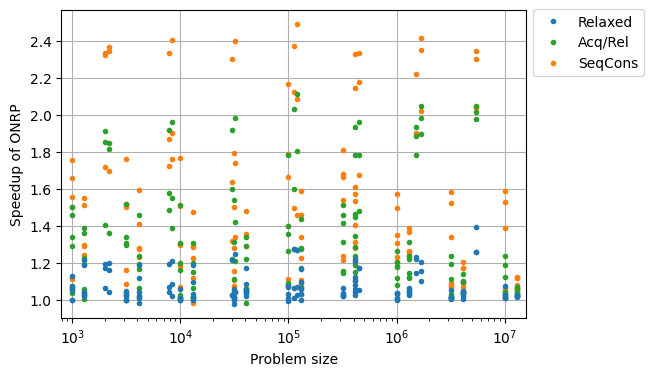

In [106]:
def onrp_scatter_chart(rows, algs_ptypes):
    marker = ".";
    
    fig, ax = plt.subplots(figsize=(6, 4));
    for (s, o, opt, v) in bench_columns:
        if opt:
            continue;
        if not v.endswith("simple"):
            continue;

        rt_col = cols2rt(s, o, opt, v);
        rt_col_cmp = cols2rt(s, o, True, v);
        
        for (a, pt) in algs_ptypes:
            alg_rows = rows.loc[
                (rows.index.get_level_values('algorithm') == a) &
                (rows.index.get_level_values('problem_type') == pt)
                , :
            ];
            ax.scatter(
                alg_rows.index.get_level_values('problem_size'),
                alg_rows[rt_col] / alg_rows[rt_col_cmp],
                color=order_color[o],
                marker=marker,
                zorder=3+["seqcons", "acqrel", "relaxed"].index(o),
                #marker=alg_marker[a],
            )
#             ax.plot(
#                 alg_rows.index.get_level_values('problem_size'),
#                 alg_rows[rt_col] / alg_rows[rt_col_cmp],
#                 color="black",
#                 alpha=0.2,
#                 linestyle="--",
#                 zorder=0
#             )
        ax.set_xscale("log")
        ax.grid(True, zorder=0)
        #ax.set_xlabel("Runtime (ms)")
        ax.set_xlabel("Problem size")
        ax.set_ylabel("Speedup of ONRP")
        ax.set_xlim(10**2.9, 10**7.2);
    
    #ax.axvline(70656, color=threads_color, alpha=threads_alpha, linestyle=threads_ls);
    
    patches = [
        Line2D(
            [0],
            [0],
            color=order_color[o],
            label=f"{f_order[o]}",
            marker=marker,
            linestyle="None"
        ) for o in ["relaxed", "acqrel", "seqcons"]
    ];
    
    fig.legend(handles=patches, bbox_to_anchor=(0.9, 0.9), loc="upper left")
    plt.show()

onrp_scatter_chart(prepped, algs_ptypes);

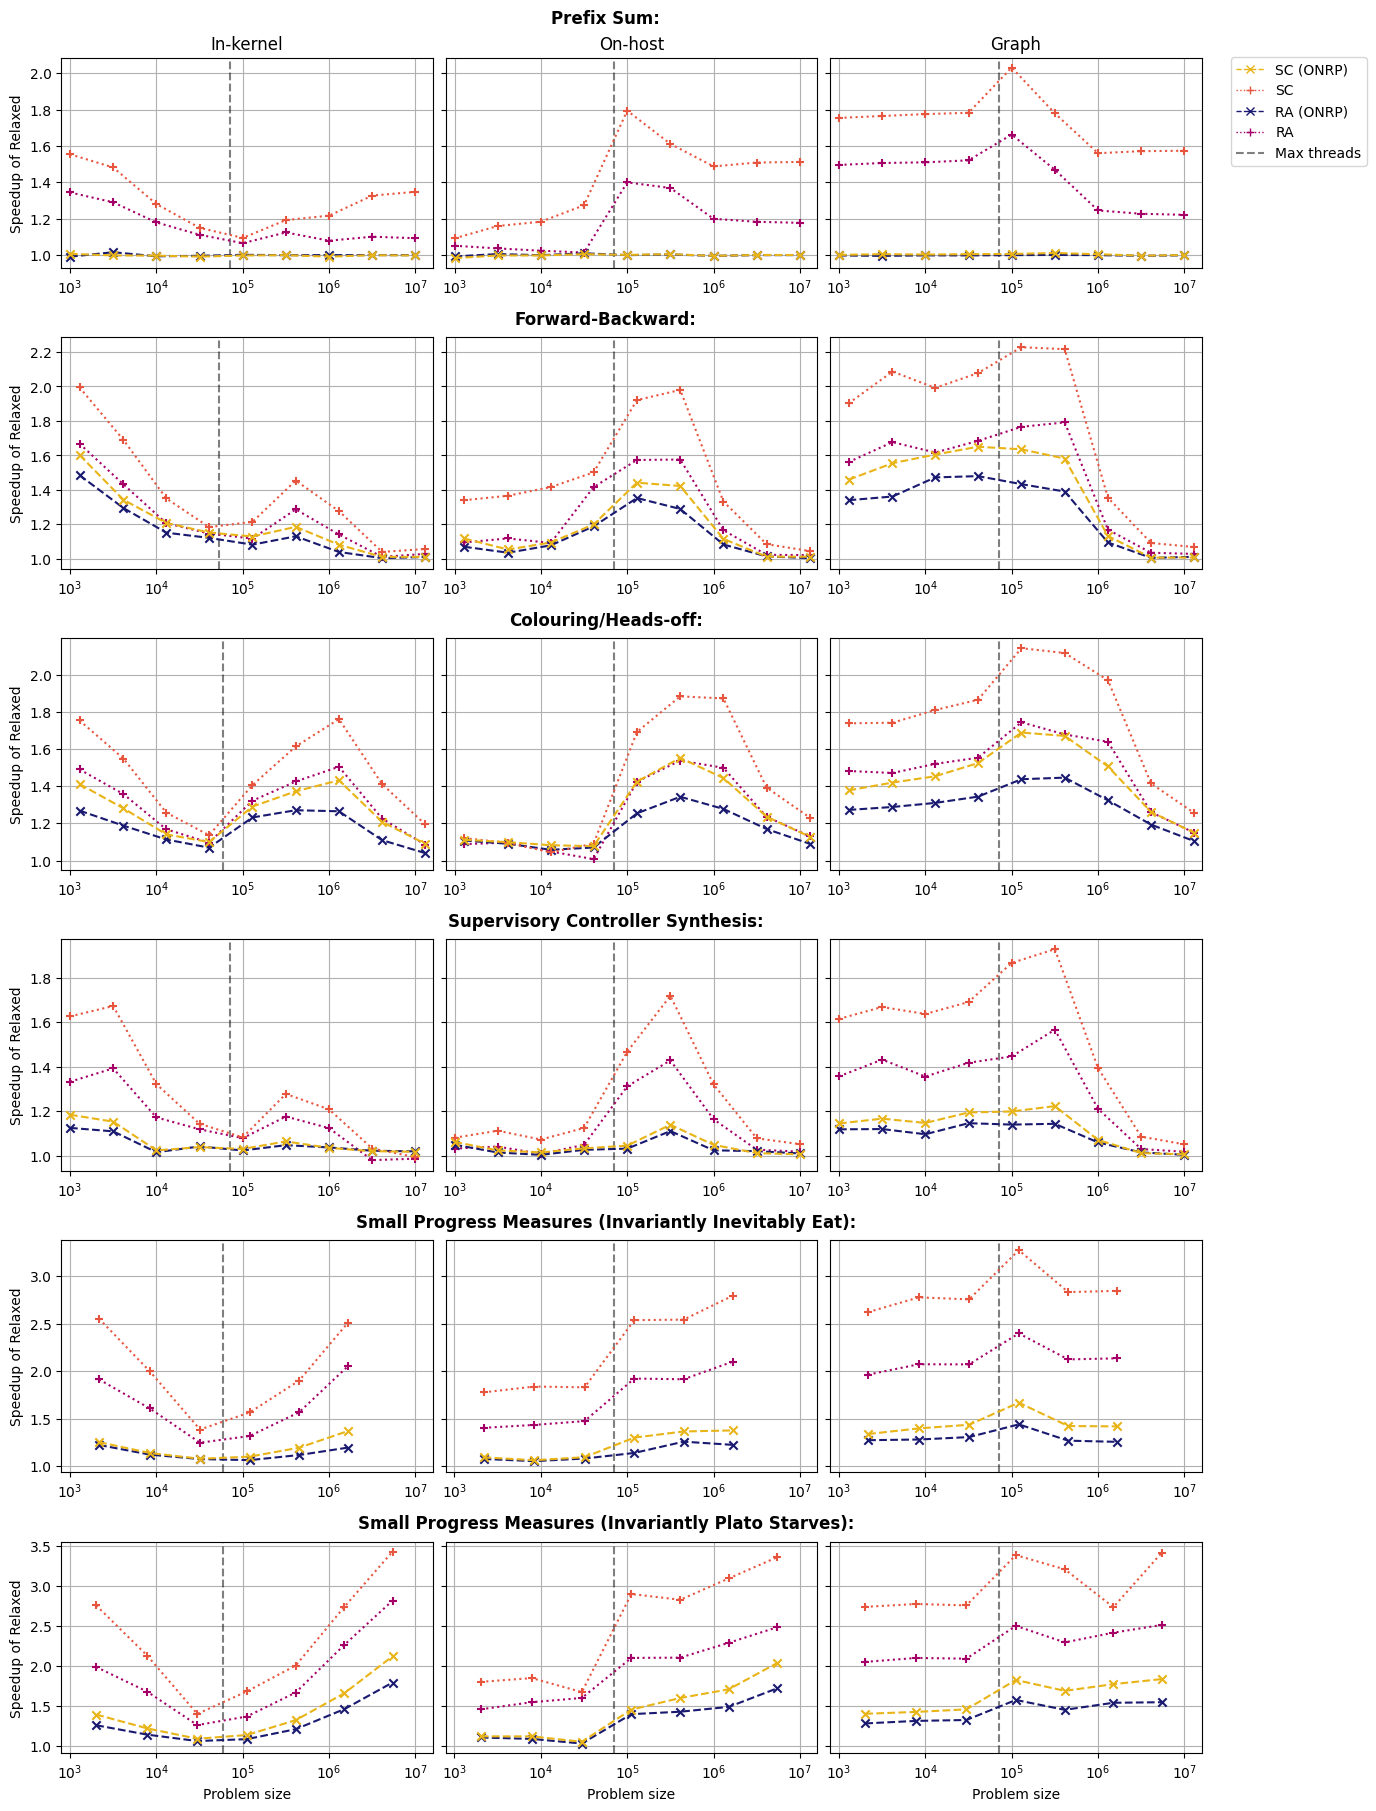

In [150]:
# returns (color, marker, linestyle, line-alpha)
style = {
#     ("acqrel", True) : ("#191970", "x", "--", 0.7),
#     ("acqrel", False) : ("#191970", "+", ":", 1),
#     ("seqcons", True) : ("#b50709", "x", "--", 0.7),
#     ("seqcons", False) : ("#b50709", "+", ":", 1),
    ("acqrel", True) : ("#191970", "x", "--", 1),
    ("acqrel", False) : ("#a50068", "+", ":", 1),
    ("seqcons", True) : ("#e8b417", "x", "--", 1),
    ("seqcons", False) : ("#e7553f", "+", ":", 1),
}


def memorder_chart(rows, algs_ptypes, ONRP):
    schedules = ["in-kernel", "on-host", "graph"];
    def row(alg_pt):
        return algs_ptypes.index(alg_pt);
    
    def col(s):
        return schedules.index(s);
    
    fig = plt.figure(constrained_layout=True, figsize=(12, 3 * len(algs_ptypes)));
    subfigs_rows = fig.subfigures(nrows=len(algs_ptypes), ncols=1)
    axs = [subfigs_rows[r].subplots(nrows=1, ncols=3, sharey=True) for r in range(len(algs_ptypes))];
    
    for (r, sf) in enumerate(subfigs_rows):
        alg = algs_ptypes[r][0];
        p_type = algs_ptypes[r][1];
        name = f_alg[alg];
        sub_name = f" ({p_type})" if alg == "SPM" else "";
        sf.suptitle(f'{name}{sub_name}:', fontweight="bold");
    
    for (r, ax_row) in enumerate(axs):
        for (c, ax) in enumerate(ax_row):
            ax.set_xlim(10**2.9, 10**7.2);
            ax.grid(True);
            ax.set_xticks([10**(3+n) for n in range(5)]);
            ax.set_xticklabels([f"$10^{3+n}$" for n in range(5)]);
            ax.set_xscale("log");
            ax.tick_params(axis='x', which='minor', bottom=False);
            ax.axvline(max_threads(schedules[c], algs_ptypes[r][0]), color=threads_color, alpha=threads_alpha, linestyle=threads_ls);
            if c == 0:
                ax.set_ylabel("Speedup of Relaxed")
            if r == 0:
                ax.set_title(f_schedule[schedules[c]]);
            if r == len(axs) - 1:
                ax.set_xlabel("Problem size")
        
    for ((a, pt), (s, o, opt, v)) in itertools.product(algs_ptypes, bench_columns):
        if opt not in ONRP:
            continue;
        if o == "relaxed":
            continue;
        # Already implied by order == relaxed
        if v.endswith("simple") == False:
            continue;
        
        c = col(s);
        r = row((a, pt));
        ax = axs[r][c];
        alg_rows = rows.loc[
            (rows.index.get_level_values('algorithm') == a) &
            (rows.index.get_level_values('problem_type') == pt)
            , :
        ];
        
        rt_col = cols2rt(s, o, opt, v);
        rt_col_cmp = cols2rt(s, "relaxed", opt, v);
        
        (color, marker, linestyle, line_alpha) = style[(o, opt)];
        ax.scatter(
            alg_rows.index.get_level_values('problem_size'),
            alg_rows[rt_col] / alg_rows[rt_col_cmp],
            color=color,
            zorder=3,
            marker=marker
        )
        ax.plot(
            alg_rows.index.get_level_values('problem_size'),
            alg_rows[rt_col] / alg_rows[rt_col_cmp],
            color=color,
            zorder=3,
            linestyle=linestyle, 
            alpha=line_alpha
        )

    patches = [
        Line2D(
            [0],
            [0],
            color=style[(o, opt)][0],
            linestyle=style[(o, opt)][2],
            label=f"{f_order[o]}{' (ONRP)' if opt else ''}",
            linewidth=1,
            marker=style[(o, opt)][1]
        ) for (o, opt) in itertools.product(["seqcons", "acqrel"], ONRP)
    ];
    
    patches.append(Line2D([0], [0], color=threads_color, alpha=threads_alpha, linestyle=threads_ls, label="Max threads"))
    
    fig.legend(handles=patches, bbox_to_anchor=(1.14, 0.975));
    
    plt.savefig(f"memorder-impact.svg", bbox_inches = 'tight');
    plt.show();

apt = algs_ptypes.copy();
#apt.remove(("prefix_sum", "Random"));
memorder_chart(prepped, apt, [True, False])

In [ ]:
def schedule_chart(alg, p_type, data, seq_data, relative = False, per_psize = False, schedules = None):
    assert(not(relative and per_psize));
    
    rows = data[(data["algorithm"] == alg) & (data["problem_type"] == p_type)];
    if schedules is not None:
        rows = rows[rows["schedule"].isin(schedules)];

    voting = sorted(list(set(rows.groupby(["schedule", "voting-strat"]).groups.keys())));
    prepped = pd.concat([
        rows[
            (rows["schedule"] == s) &
            (rows["voting-strat"] == v) &
            (rows["memorder"] == "relaxed") &
            (rows["weak_non_racing"] == True)
        ][["problem_size", "runtime"]]
        .set_index("problem_size")
        .sort_index()
        .rename(columns={"runtime": f"rt_{s}_{v}"})
        for (s, v) in voting
    ], axis = 1);
    
    colors = {
        "graph": "C0",
        "on-host": "C1",
        "in-kernel": "C2",
    };
    
    marker = {
        "graph-simple": ("*", 8, "C3"),
        "in-kernel-simple": ("*", 8, "C4"),
        "on-host-simple": ("*", 8, "C5"),
        "on-host-alternating": ("D", 5, "C6"),
        "in-kernel-alternating": ("D", 5, "C7"),
        "graph-shared": ("+", 8, "C8"),
        "graph-shared-banks": ("x", 8, "C9"),
        
    };
    
    fig, ax = plt.subplots(figsize=(6, 4));
    
    rel = ' relative' if relative else '';
    per_instance = ' per instance' if per_psize else '';
    title = (f"The{rel} runtime{per_instance} of schedule and voting strategies compared.\n"
            f"({alg}{f': {p_type}' if not p_type.startswith('Random') else ''})"
            );
    plt.suptitle(title, y=1.07);
    if relative:
        ax.set_ylabel(f"Relative runtime{per_instance} (%)");
    else:
        ax.set_ylabel(f"Runtime{per_instance} (ms)");
        ax.set_yscale("log");
    
    ax.grid(True);
    ax.set_xlim(10**3, 10**7);
    ax.set_xscale("log");
    ax.set_xlabel("Problem size");
    
    for (s, v) in voting:
        if per_psize:
            Y = prepped[f"rt_{s}_{v}"] / prepped.index;
        elif relative:
            Y = (prepped[f"rt_{s}_{v}"] / prepped[f"rt_graph_graph-simple"]) * 100;
        else:
            Y = prepped[f"rt_{s}_{v}"];

        (m, ms, mc) = marker[v];
        ax.plot(
            prepped.index,
            Y,
            label=v,
            color=colors[s],
            marker=m,
            markersize=ms,
            linestyle='--',
            markerfacecolor=mc,
            markeredgecolor=mc
        );
    
    s_data = seq_data[(seq_data["alg"] == alg) & (seq_data["problem_type"] == p_type)];
    if len(s_data.index) > 0:
        ax.plot(
            s_data["problem_size"],
            s_data["runtime"] if not per_psize else s_data["runtime"] / s_data["problem_size"],
            label="Sequential",
            color="C10"
        );
    
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left");
    plt.show();

In [ ]:
for (alg, p_type) in algs:
    schedule_chart(alg, p_type, data, seq_data, relative=False, per_psize=False);


In [88]:
def onrp_chart(algs, data):
    fig = plt.figure(constrained_layout=True, figsize=(10, 2.5 * len(algs)));
    subfigs = fig.subfigures(nrows=len(algs), ncols=1)
    
    for a, subfig in enumerate(subfigs):
        (alg, p_type) = algs[a];
        rows = data[(data["algorithm"] == alg) & (data["problem_type"] == p_type)];
        name = f_alg[alg];
        sub_name = f" ({p_type})" if alg == "SPM" else "";
        subfig.suptitle(f'{name}{sub_name}:', fontweight="bold");
        axs = subfig.subplots(nrows=1, ncols=3, sharey=True);
        
        
        prepped = pd.concat([
            rows[
                (rows["schedule"] == s) &
                (rows["voting-strat"] == v) &
                (rows["memorder"] == o) &
                (rows["weak_non_racing"] == opt)
            ][["problem_size", "runtime"]]
            .set_index("problem_size")
            .rename(columns={"runtime": f"rt_{s}_{o}_{opt}"})
            for ((s, v), o, opt) in itertools.product(voting, order, [True, False])
        ], axis = 1);
        prepped.sort_index(inplace=True);

        axs[0].set_ylabel("ONRP speedup (%)");
        for ((sf, (s, v)), o) in itertools.product(enumerate(voting), order):
            Y = (prepped[f"rt_{s}_{o}_False"] / prepped[f"rt_{s}_{o}_True"]) * 100;
            axs[sf].plot(
                prepped.index,
                Y,
                color=colors[o],
                linestyle="-",
                marker="o"
            );
            
            if a == 0:
                axs[sf].set_title(f_schedule[s]);

            if a == len(algs)-1:
                axs[sf].set_xlabel("Problem size");
            
        for i in range(3):
#             axs[i].axvline(max_resident_threads, color=threads_color, alpha=threads_alpha, linestyle=threads_ls);
            axs[i].set_xlim(10**3, 10**7.15);
            axs[i].set_xticks([10**(3+n) for n in range(5)]);
            axs[i].set_xticklabels([f"$10^{3+n}$" for n in range(5)]);
            axs[i].grid(True);
            axs[i].yaxis.set_minor_locator(AutoMinorLocator(2))
            axs[i].set_xscale("log");
            axs[i].tick_params(axis='x', which='minor', bottom=False);

    patches = [
        Line2D(
            [0],
            [0],
            color=colors[o],
            label=f"{f_order[o]}",
            linewidth=1,
            marker="x"
        ) for o in order
    ]; 
    fig.legend(handles=patches, bbox_to_anchor=(1.18, 0.97));

    def prune(name):
        return name.replace(" ", "-").replace("/", "-");
    
    #plt.savefig(f"memorder-impact.svg", bbox_inches = 'tight');
    plt.show();


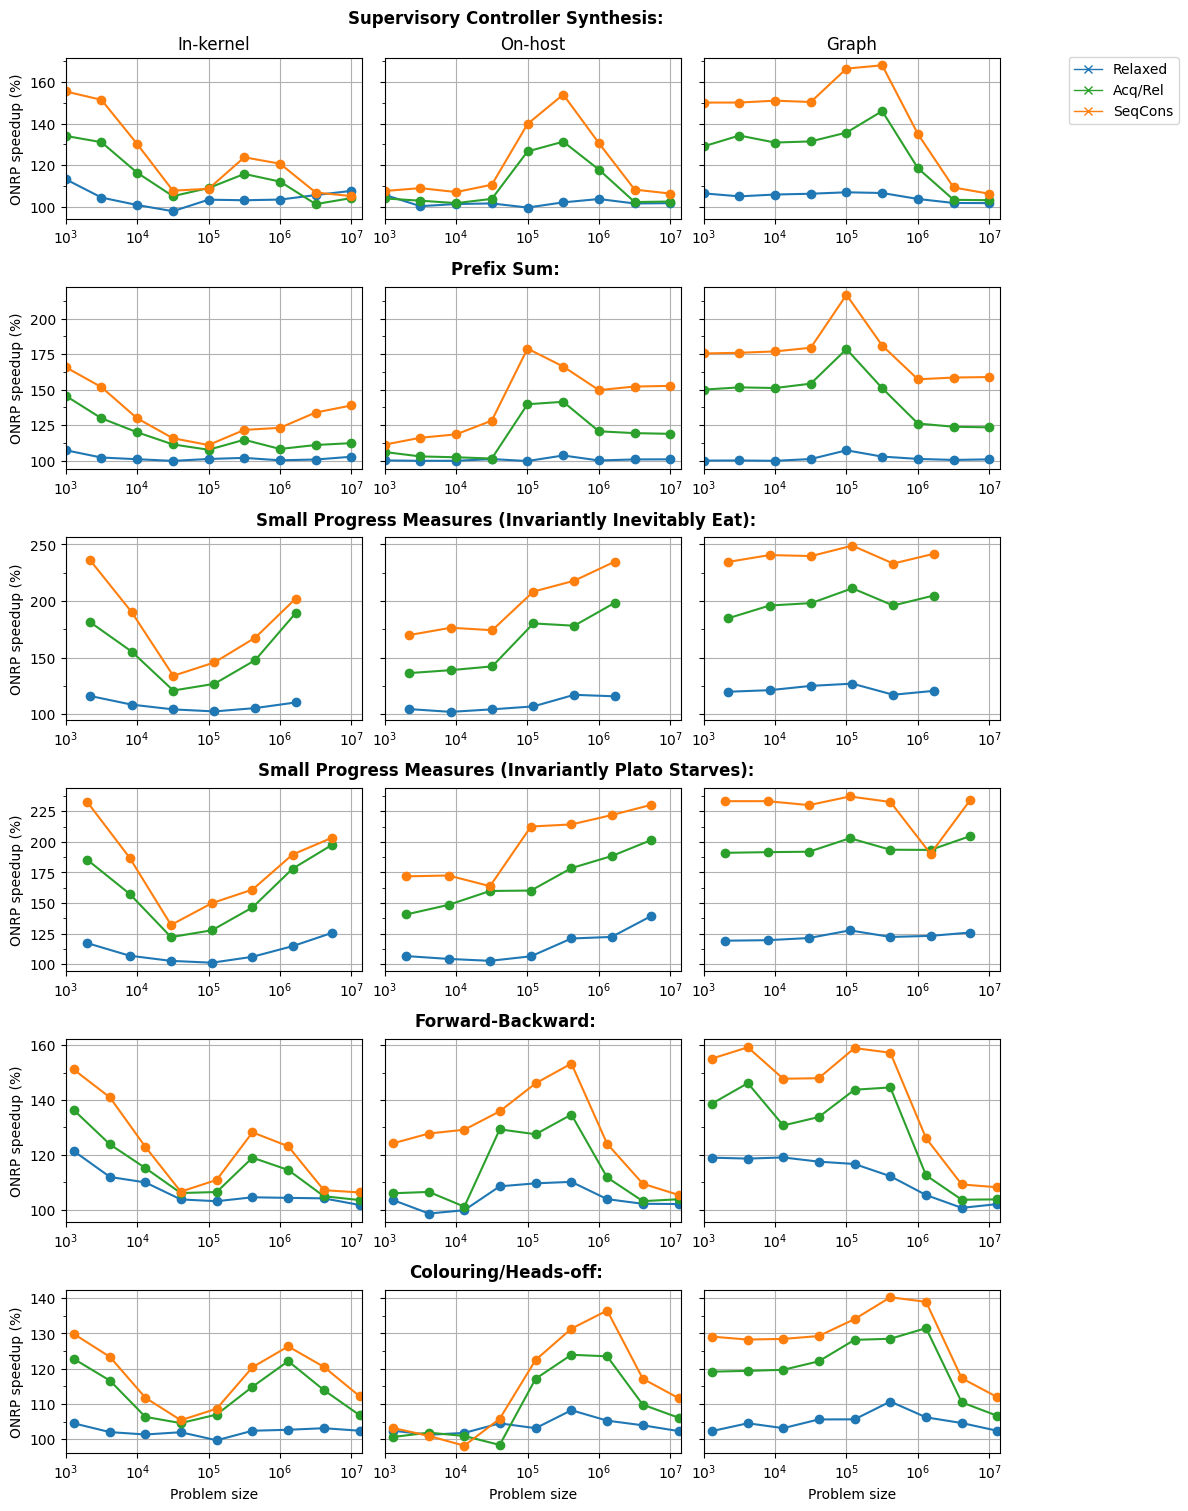

In [90]:
onrp_chart(algs_ptypes, prepped);